In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames.

We will restrict to some common European languages.

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation.

Foresee a suitable character for the end of the word, e.g. 'END'.

In [5]:
srcdir = '/content/drive/MyDrive/Colab Notebooks/name_classification/data/names'
languages = ["English","French","Italian","German","Spanish"]

In [6]:
# inspect the data directory
def findFiles(path):
    return glob.glob(path)

In [7]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/Czech.txt
/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/Italian.txt
/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/Spanish.txt
/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/Japanese.txt
/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/Dutch.txt
/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/French.txt
/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/Irish.txt
/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/Polish.txt
/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/Scottish.txt
/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/Russian.txt
/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/English.txt
/content/drive/MyDrive/Colab Notebooks/name_classification/data/names/Greek.txt
/content/drive/MyDrive/C

In [8]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories:
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [9]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abandonato,Italian
1,Abatangelo,Italian
2,Abatantuono,Italian
3,Abate,Italian
4,Abategiovanni,Italian


In [10]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [11]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [12]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors.

In [13]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [14]:
test_split = 0.2

### START YOUR CODE
# Shuffle and split names data

names = names.sample(frac=1).reset_index(drop=True)
train = names[:int(len(names)*(1-test_split))]
test = names[int(len(names)*(1-test_split)):]

### END YOUR CODE

In [15]:
### START YOUR CODE

# Map train and test data into vector space (one-hot-vectors)

X_train = np.array([name_representation(name, maxlen) for name in train.name])
Y_train = np.array([lang_representation(lang, language_to_index) for lang in train.lang])

X_test = np.array([name_representation(name, maxlen) for name in test.name])
Y_test = np.array([lang_representation(lang, language_to_index) for lang in test.lang])

### END YOUR CODE

### Utilities

In [16]:
def performance_plots(model, X_test, Y_test, log, epochs):
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [17]:
import sklearn
import pandas as pd

def compute_confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    nsamples = Y_test.shape[0]
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({languages[i] : cm[:,i] for i in range(len(languages))}, languages)
    return df, cm

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [18]:
### START YOUR CODE

# SImpleRNN, single layer with tf.keras....

model = Sequential()
model.add(SimpleRNN(128, input_shape=(maxlen, len_alphabet)))
model.add(Dense(len(languages), activation='softmax'))

### END YOUR CODE

In [19]:
### START YOUR CODE
batch_size=64
nepochs = 10

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=nepochs, batch_size=batch_size)

### END YOUR CODE

Epoch 1/10
71/71 [==============================] - 3s 18ms/step - loss: 1.0495 - accuracy: 0.6463 - val_loss: 0.9390 - val_accuracy: 0.6629
Epoch 2/10
71/71 [==============================] - 1s 15ms/step - loss: 0.8379 - accuracy: 0.7029 - val_loss: 0.7812 - val_accuracy: 0.7192
Epoch 3/10
71/71 [==============================] - 1s 16ms/step - loss: 0.7478 - accuracy: 0.7297 - val_loss: 0.7315 - val_accuracy: 0.7368
Epoch 4/10
71/71 [==============================] - 2s 24ms/step - loss: 0.6997 - accuracy: 0.7489 - val_loss: 0.7699 - val_accuracy: 0.7298
Epoch 5/10
71/71 [==============================] - 2s 24ms/step - loss: 0.6679 - accuracy: 0.7562 - val_loss: 0.7367 - val_accuracy: 0.7447
Epoch 6/10
71/71 [==============================] - 1s 16ms/step - loss: 0.6256 - accuracy: 0.7762 - val_loss: 0.6647 - val_accuracy: 0.7729
Epoch 7/10
71/71 [==============================] - 1s 14ms/step - loss: 0.6135 - accuracy: 0.7824 - val_loss: 0.6869 - val_accuracy: 0.7667
Epoch 8/10
71

Train accuracy (end): 0.8039647340774536
Train accuracy (max): 0.8039647340774536
Test accuracy (end) : 0.7684859037399292
Test accuracy (max) : 0.7728873491287231


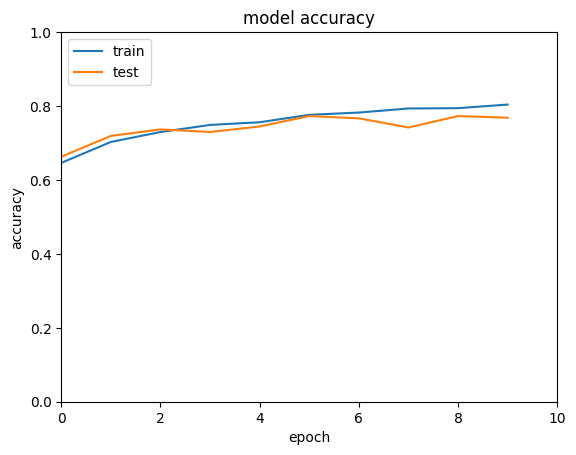

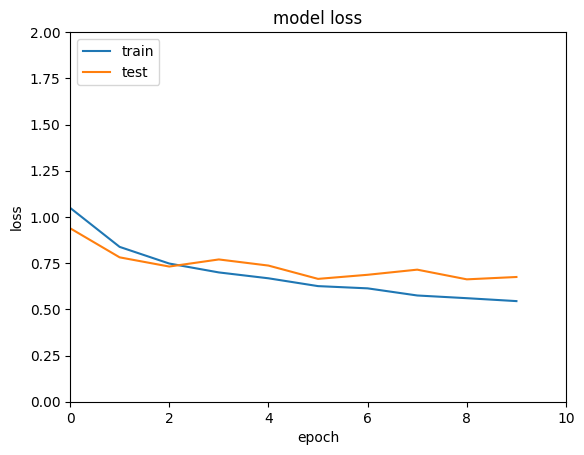

36/36 [==============================] - 0s 4ms/step


,English,French,Italian,German,Spanish
English,112,4,1,24,3
French,32,12,2,20,3
Italian,13,1,8,28,2
German,22,2,3,669,30
Spanish,2,3,1,67,72


In [20]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = compute_confusion_matrix(model, X_test, Y_test)
df

### Handle Class Imbalance, Resampling

We can observe a quite significant class imbalance in the data.<br>

One way to compensate for that would be to use resampling.

In [21]:
def handle_imbalance(names, languages):

    ### START YOUR CODE

    # treat class imbalance
    # upsample the minority classes
    # get the number of samples in each class
    n_samples = names.groupby('lang')['name'].count()
    max_samples = n_samples.max()
    names_upsampled = names.copy()
    for lang in languages:
        lang_samples = names[names['lang'] == lang]
        n_samples = lang_samples.shape[0]
        if n_samples < max_samples:
            n_samples_to_add = max_samples - n_samples
            samples_to_add = lang_samples.sample(n=n_samples_to_add, replace=True)
            names_upsampled = pd.concat([names_upsampled, samples_to_add])

    ### END YOUR CODE
    return names_upsampled


In [22]:
names_upsampled = handle_imbalance(names, languages)
names_upsampled.groupby('lang')['name'].count()/len(names_upsampled)

lang
English    0.2
French     0.2
German     0.2
Italian    0.2
Spanish    0.2
Name: name, dtype: float64

#### Train Model

Again prepare train and test data (X_train, X_test, Y_train, Y_test)

Train the same model as above with the new data.

In [23]:
### START YOUR CODE

X_train = np.array([name_representation(name, maxlen) for name in names_upsampled.name])
Y_train = np.array([lang_representation(lang, language_to_index) for lang in names_upsampled.lang])

X_test = np.array([name_representation(name, maxlen) for name in test.name])
Y_test = np.array([lang_representation(lang, language_to_index) for lang in test.lang])

### END YOUR CODE

Epoch 1/10
287/287 [==============================] - 6s 15ms/step - loss: 1.0416 - accuracy: 0.5789 - val_loss: 0.8825 - val_accuracy: 0.6162
Epoch 2/10
287/287 [==============================] - 4s 12ms/step - loss: 0.7274 - accuracy: 0.7207 - val_loss: 0.8349 - val_accuracy: 0.6743
Epoch 3/10
287/287 [==============================] - 5s 17ms/step - loss: 0.5144 - accuracy: 0.8082 - val_loss: 0.5304 - val_accuracy: 0.7993
Epoch 4/10
287/287 [==============================] - 4s 15ms/step - loss: 0.3932 - accuracy: 0.8584 - val_loss: 0.5810 - val_accuracy: 0.7790
Epoch 5/10
287/287 [==============================] - 4s 13ms/step - loss: 0.3154 - accuracy: 0.8903 - val_loss: 0.3981 - val_accuracy: 0.8600
Epoch 6/10
287/287 [==============================] - 4s 13ms/step - loss: 0.2806 - accuracy: 0.9050 - val_loss: 0.3968 - val_accuracy: 0.8732
Epoch 7/10
287/287 [==============================] - 5s 18ms/step - loss: 0.2452 - accuracy: 0.9153 - val_loss: 0.2753 - val_accuracy: 0.8970

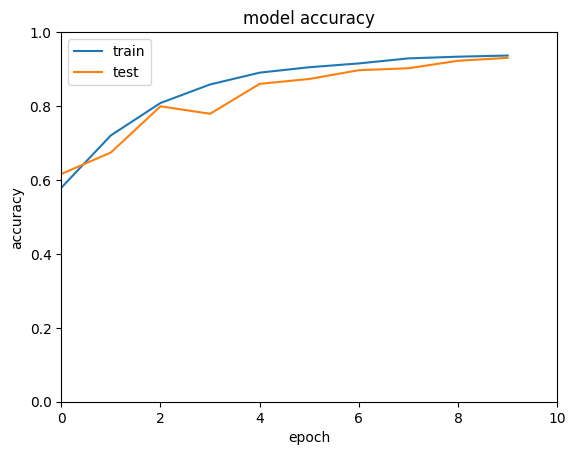

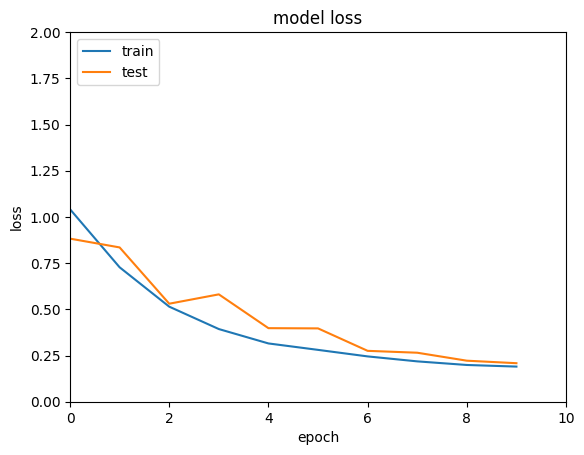

36/36 [==============================] - 0s 3ms/step


,English,French,Italian,German,Spanish
English,139,3,0,1,1
French,3,64,1,0,1
Italian,0,0,49,1,2
German,9,4,23,668,22
Spanish,0,0,3,5,137


In [24]:
### START YOUR CODE

# train model

model = Sequential()
model.add(SimpleRNN(128, input_shape=(maxlen, len_alphabet)))
model.add(Dense(len(languages), activation='softmax'))

batch_size=64
nepochs = 10

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=nepochs, batch_size=batch_size)

performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = compute_confusion_matrix(model, X_test, Y_test)
df

### END YOUR CODE

#### Findings

The recall for the less represented classes increased.



#### In which situations is class imbalance treatment important and why?  

When all classes have the same importance.

### Implement Model with several SimpleRNN Layers

In [25]:
### START YOUR CODE

# using several simpleRNN layers
model = Sequential()
model.add(SimpleRNN(128, input_shape=(maxlen, len_alphabet), return_sequences=True))
model.add(SimpleRNN(128))
model.add(Dense(len(languages), activation='softmax'))

### END YOUR CODE

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 18, 128)           25984     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 59525 (232.52 KB)
Trainable params: 59525 (232.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
287/287 [==============================] - 19s 47ms/step - loss: 0.9579 - accuracy: 0.6138 - val_loss: 0.7638 - val_accuracy: 0.7060
Epoch 2/10
287/287 [==============================] - 10s 34ms/step - loss: 0.5449 - accuracy: 0.7933 - val_loss: 0.5609 - val_accuracy: 0.7658
Epoch 3/10
287/287 [==============================] - 17s 60ms/step - loss: 0.3870 - accuracy: 0.8637 - val_loss: 0.4172 - val_accuracy: 0.8539
Epoch 4/10
287/287 [==============================] - 9s 32ms/step - loss: 0.3065 - accuracy: 0.8924 - val_loss: 0.3121 - val_accuracy: 0.8926
Epoch 5/10
287/287 [==============================] - 10s 35ms/step - loss: 0.2533 - accuracy: 0.9132 - val_loss: 0.4090 - val_accuracy: 0.8583
Epoch 6/10
287/287 [==============================] - 10s 33ms/step - loss: 0.2240 - accuracy: 0.9266 - val_loss: 0.3027 - val_accuracy: 0.8926
Epoch 7/10
287/287 [==============================] - 9s 31ms/step - loss: 0.2116 - accuracy: 0.9281 - val_loss: 0.2805 - val_accuracy: 0

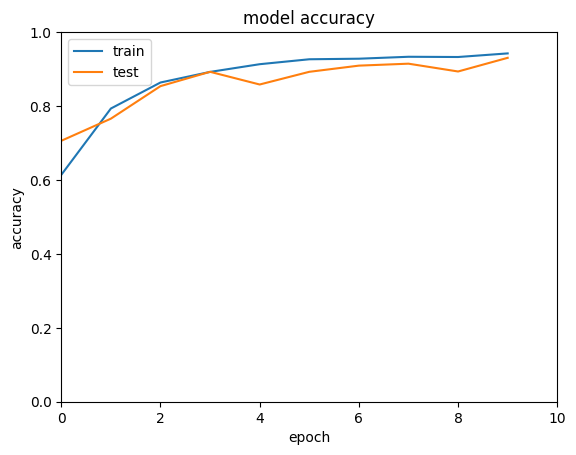

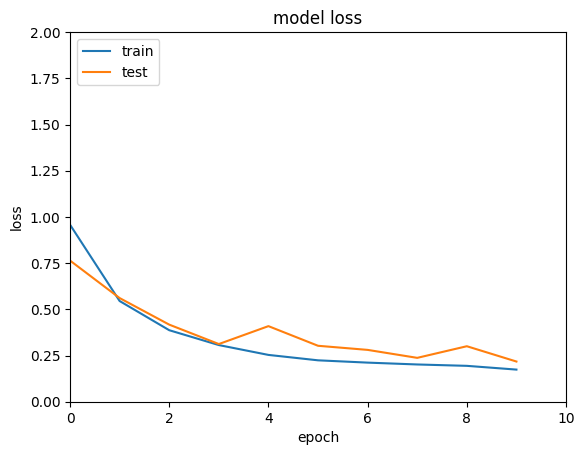

36/36 [==============================] - 1s 12ms/step


,English,French,Italian,German,Spanish
English,135,6,3,0,0
French,0,68,1,0,0
Italian,0,1,51,0,0
German,1,6,21,667,31
Spanish,0,0,3,6,136


In [26]:
### START YOUR CODE

# train
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=nepochs, batch_size=batch_size)

performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = compute_confusion_matrix(model, X_test, Y_test)
df

### END YOUR CODE

#### Findings

Adding one simpleRNN layer didn't increase the performance significantly.
